# Fake news detection

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Importing the ISOT dataset files

In [36]:
%matplotlib inline

d_true = pd.read_csv("../Data/True.csv")
d_fake = pd.read_csv("../Data/Fake.csv")

### 1. Data preprocessing

In [37]:
d_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [38]:
d_true.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [39]:
d_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [40]:
d_fake.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [41]:
# add a column with the name label that has value 1 for reliable news and 0 for fake news

d_true["label"] = 1
d_fake["label"] = 0

**True Dataset's WordCloud**

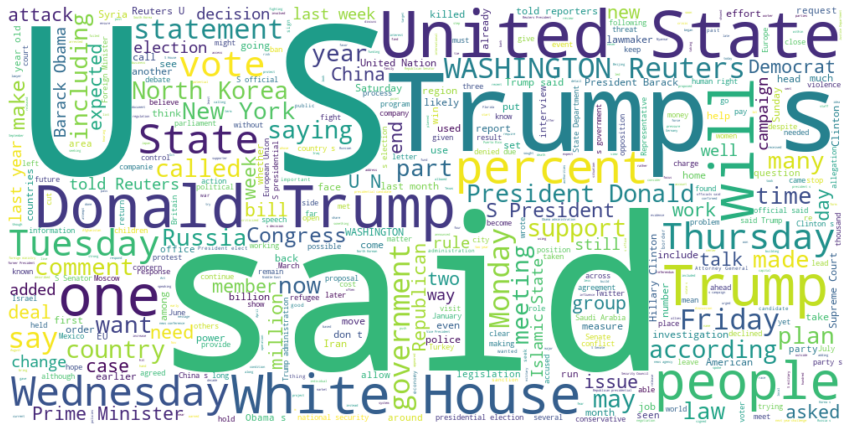

In [42]:
#!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500, background_color="rgba(255, 255, 255, 0)", stopwords = STOPWORDS).generate(" ".join(d_true.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.savefig("../True dataset's world cloud.png", bbox_inches='tight')

**fake Dataset's WordCloud**

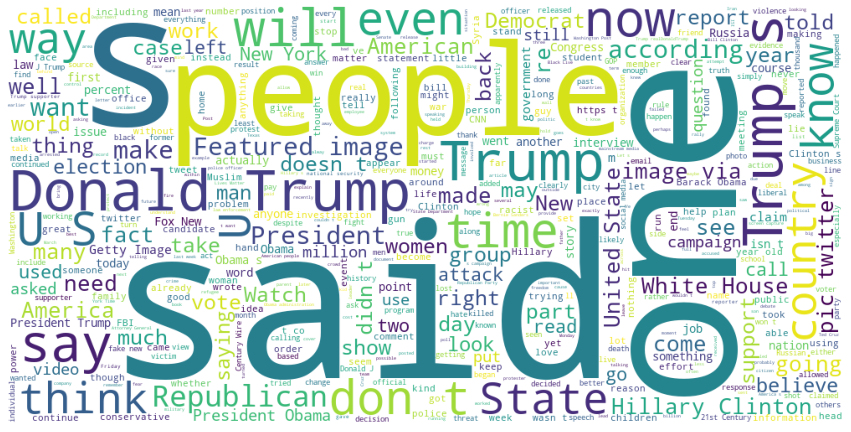

In [43]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , background_color="rgba(255, 255, 255, 0)", stopwords = STOPWORDS).generate(" ".join(d_fake.text))
plt.imshow(wc)
plt.axis('off')
plt.savefig("../Fake dataset's world cloud.png", bbox_inches='tight')

In [44]:
d_true['text'] = d_true['title'] +" "+ d_true['text']
d_fake['text'] = d_fake['title'] +" "+ d_fake['text']

In [45]:
# drop the unnecessary columns

d_true.drop(["title", "subject", "date"], axis=1, inplace= True)
d_fake.drop(["title", "subject", "date"], axis=1, inplace= True)

In [46]:
# concatenate the two dataframes and shuffle the result

data = pd.concat([d_true, d_fake], axis=0, ignore_index = True)
data = shuffle(data)

data = data.reset_index()
data.drop(["index"], axis=1, inplace= True)
data.head()

,text,label
0,ELIZABETH “Fauxchahontas” WARREN CAUGHT LYING ...,0
1,Eric Trump Tries To Defend Donald On Tax Evas...,0
2,SECURITY ANALYST: Letting Muslim Refugees In I...,0
3,Kenyan police assaulted and raped women during...,1
4,TOP TEN Clinton Scandals That Wikileaks Expose...,0


In [47]:
# check if there is any

data.isnull().sum()

text     0
label    0
dtype: int64

In [48]:
data.shape

(44898, 2)

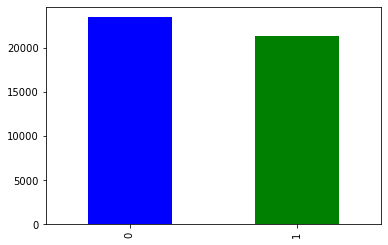

In [49]:
#check the data distribution

data.label.value_counts().plot(kind='bar', color=['b', 'g'])

In [50]:
data.label.value_counts()

0    23481
1    21417
Name: label, dtype: int64

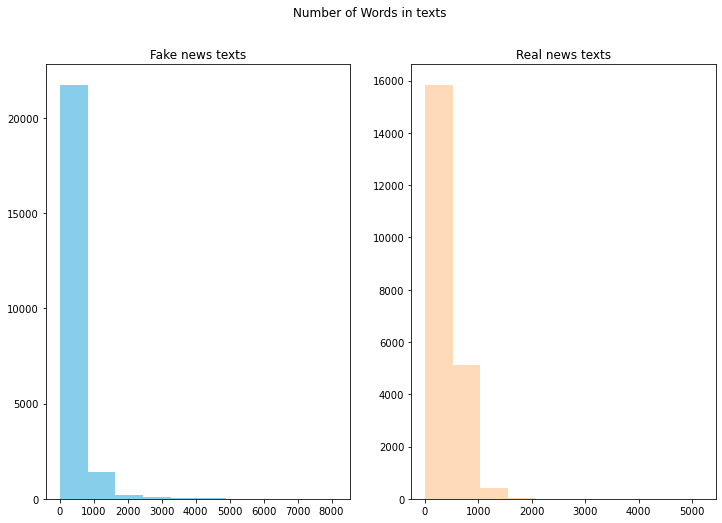

In [51]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news texts')

text_len=data[data['label']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news texts')
fig.suptitle('Number of Words in texts')
plt.show()

In [52]:
#!pip install nltk
import nltk
from nltk.corpus import stopwords

#nltk.download("punkt")
#nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
def process(text):
  text = text.lower()
  words = nltk.word_tokenize(text)
  new_words= [word for word in words if word.isalnum() and word not in stop_words]
  text = " ".join(new_words)
  return text

In [53]:
data = shuffle(data)

data['text'] = data['text'].apply(process)
X = data['text'].to_frame()
Y = data['label'].to_frame()

Text(0.5, 1.0, 'number of words')

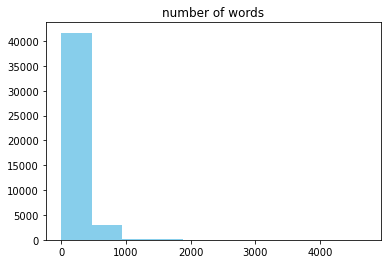

In [54]:
# Number of words after removing stopwords
text_len=X['text'].str.split().map(lambda x: len(x))
plt.hist(text_len,color='SkyBlue')
plt.title('number of words')

In [55]:
Avg_len = text_len.mean()
Avg_len = round(Avg_len)
lst = []
for i in X['text']:
  tmp = i.split()
  lst.extend(tmp)
lst = set(lst)
Vocab_size = len(lst)
print("the average number of words in the texts is : ", Avg_len)
print("the texts contains", Vocab_size, "unique words")

the average number of words in the texts is :  233
the texts contains 108192 unique words


### 2. Tokenizing the text

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=Vocab_size)
tokenizer.fit_on_texts(X['text'])
sequences = tokenizer.texts_to_sequences(X['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 108192 unique tokens.


In [57]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

data = pad_sequences(sequences, maxlen=Avg_len+2, padding='post', truncating='post')

### 3. Spliting the data into train / test sets

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.25, random_state=30)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(33673, 235) (11225, 235) (33673, 1) (11225, 1)


### 4. Using GloVe for Word Embeddings

In [59]:
# Import tensor representations for words
# GloVe is an unsupervised learning algorithm for obtaining vector representations for words

embeddings_index = {};
with open("../../../glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((Vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;


100


In [60]:
print(embeddings_matrix.shape)

(108193, 100)


### 4.Building the architecture of the model

In [91]:
import tensorflow as tf
# Building the architecture of the model
     
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, 100, weights=[embeddings_matrix], trainable = False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, validation_split=0.1, batch_size=32, shuffle=True, callbacks=[early_stop])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 100)         10819300  
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128)               84480     
_________________________________________________________________
dense_32 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 33        
Total params: 10,907,941
Trainable params: 88,641
Non-trainable params: 10,819,300
_________________________________________________________________
Epoch 1/10
948/948 [==============================] - 162s 164ms/step - loss: 0.3148 - accuracy: 0.8844 - val_loss: 0.0423 - val_accuracy: 0.9852
Epoch 2/10
948/948 [==============================] - 153s 161ms/step - loss: 0.0262 - a

### 5. Model Ealuation

In [92]:
model.evaluate(X_test, Y_test)

351/351 [==============================] - 18s 50ms/step - loss: 0.0114 - accuracy: 0.9979


[0.01136211957782507, 0.997861921787262]

In [87]:
Y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [88]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(Y_test['label']), Y_pred)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9977728285077951
